# WSI - zadanie 3

Artur Kempiński
325168

Użyta technologia:

python==3.11.6

matplotlib==3.8.0

In [1]:
import random
import enum
from typing import Callable
from matplotlib import pyplot as plt

# Implementacja minimax

In [2]:
class Player(enum.Enum):
    MAX = 1
    MIN = 2

In [3]:
class Position():
    def __init__(self, tokens_left: int, player_to_move: Player, k: int):
        self.tokens_left = tokens_left
        self.player_to_move = player_to_move
        self.k = k
        
    def is_game_over(self):
        return self.tokens_left == 0

In [4]:
def generate_possible_next_possitions(current_position: Position) -> list[Position]:
    if current_position.is_game_over():
        return []
    
    possible_positions = []
    next_player = Player.MAX if current_position.player_to_move == Player.MIN else Player.MIN
    
    max_tokens_to_take = min(current_position.k, current_position.tokens_left)
    for tokens_taken in range(1, max_tokens_to_take + 1):
        tokens_left = current_position.tokens_left - tokens_taken
        possible_positions.append(Position(tokens_left, next_player, current_position.k))
        
    return possible_positions
            

In [5]:
def minimax(
    position: Position,
    depth: int,
    alpha: int,
    beta: int,
    evaluate_position: Callable[[Position], int],
    k: int
) -> int:
    if depth == 0 or position.is_game_over():
        return evaluate_position(position)
    
    possible_positions = generate_possible_next_possitions(position)
    
    match position.player_to_move:
        case Player.MAX:
            max_eval = -float('inf')
            for possible_position in possible_positions:
                max_eval = max(max_eval, minimax(possible_position, depth - 1, alpha, beta, evaluate_position, k))
                alpha = max(alpha, max_eval)
                if alpha >= beta:
                    break
            return max_eval
    
        case Player.MIN:
            min_eval = float('inf')
            for possible_position in possible_positions:
                min_eval = min(min_eval, minimax(possible_position, depth - 1, alpha, beta, evaluate_position, k))
                beta = min(beta, min_eval)
                if alpha >= beta:
                    break
            return min_eval

# Implementacja heurystyk

In [6]:
def random_eval(position: Position) -> int:
    return random.choice([-1, 1])

Heurystyka zwracająca losową ewaluację niezależnie od pozycji, będzie stanowić porównanie dla innych heurystyk

In [7]:
def simple_eval(position: Position) -> int:
    if position.is_game_over():
        match position.player_to_move:
            case Player.MAX:
                return 1
            case Player.MIN:
                return -1
    return 0

Prosta heurystyka

In [8]:
def medium_eval(position: Position) -> int:
    if position.tokens_left == 1:
        match position.player_to_move:
            case Player.MAX:
                return -1
            case Player.MIN:
                return 1
    else:
        return simple_eval(position)

Nieco ulepszony "simple eval" pozwalający ocenić wynik gry jeden poziom głębokości wyżej

In [9]:
def strong_eval(position: Position) -> int:
    tokens_left = position.tokens_left
    player = position.player_to_move
    
    is_last_token = tokens_left == 1
    if is_last_token:
        match player:
            case Player.MAX:
                return -2
            case Player.MIN:
                return 2
        
    is_specific_number_of_tokens_left = tokens_left % (position.k+1) == 1
    match player:
        case Player.MAX:
            if is_specific_number_of_tokens_left:
                return -1
            else:
                return 1
            
        case Player.MIN:
            if is_specific_number_of_tokens_left:
                return 1
            else:
                return -1
            
            

Pokazana mi przez kolegę heurystyka umożliwiająca znanie z góry wyniku gry bazując jedynie na informacji o ilości żetonów ustalonej w pierwszej turze oraz graczu rozpoczynającym rozgrywkę, niezależnie od głębokości przeszukwiania.

# Implementacja gry

In [10]:
def pick_best_next_position(current_position: Position, depth: int, evaluate_position: Callable[[Position], int]) -> Position:
    positions_with_eval = []
    
    possible_positions = generate_possible_next_possitions(current_position)
    for possible_position in possible_positions:
        eval = minimax(possible_position, depth, -float('inf'), float('inf'), evaluate_position, current_position.k)
        positions_with_eval.append((possible_position, eval))
        
    best_positions = []
    
    match current_position.player_to_move:
        case Player.MAX:
            _, best_eval = max(positions_with_eval, key=lambda x: x[1])
            for position, eval in positions_with_eval:
                if eval == best_eval:
                    best_positions.append(position)
        case Player.MIN:
            _, best_eval = min(positions_with_eval, key=lambda x: x[1])
            for position, eval in positions_with_eval:
                if eval == best_eval:
                    best_positions.append(position)
                    
    return random.choice(best_positions)

Zgodnie z poleceniem, wybierany jest losowy ruch spośród najlepszych

In [11]:
def play_game(initial_position: Position, depth: int, evaluate_position_max: Callable[[Position], int], evaluate_position_min: Callable[[Position], int]) -> Player:
    current_position = initial_position
    
    while not current_position.is_game_over():
        evaluate_position = evaluate_position_max if current_position.player_to_move == Player.MAX else evaluate_position_min
        current_position = pick_best_next_position(current_position, depth, evaluate_position)
    
    return current_position.player_to_move

# API do eksperymentów

In [12]:
def get_player_winrate_over_positions(
    starting_positions: list[Position],
    player: Player,
    depth: int,
    evaluate_position_max: Callable[[Position], int],
    evaluate_position_min: Callable[[Position], int]
) -> float:
    amount_of_games = len(starting_positions)
    player_win_counter = 0
    
    for starting_position in starting_positions:
        
        winner = play_game(starting_position, depth, evaluate_position_max, evaluate_position_min)
        
        if winner == player:
            player_win_counter += 1
    
    return (player_win_counter / amount_of_games) * 100
    

In [13]:
def generate_positions_random_n(amount_of_positions: int, k: int, starting_player: Player = None) -> list[Position]:
    positions = []
    
    for _ in range(amount_of_positions):
        n = random.randint(8, 20)
        
        if starting_player is not None:
            positions.append(Position(n, starting_player, k))
        else:
            positions.append(Position(n, random.choice([Player.MAX, Player.MIN]), k))
        
    return positions

In [14]:
def generate_positions_given_n(amount_of_positions: int, k: int, n: int, starting_player: Player = None) -> list[Position]:
    if starting_player is not None:
        return [Position(n, starting_player, k) for _ in range(amount_of_positions)]
    else:
        return [Position(n, random.choice([Player.MAX, Player.MIN]), k) for _ in range(amount_of_positions)]

In [15]:
def get_player_winrate(
    amount_of_games: int,
    player: Player,
    depth: int,
    k: int,
    evaluate_position_max: Callable[[Position], int],
    evaluate_position_min: Callable[[Position], int],
    n: int = None,
    starting_player: Player = None
) -> float:
    if n is None:
        starting_positions = generate_positions_random_n(amount_of_games, k, starting_player)
    else:
        starting_positions = generate_positions_given_n(amount_of_games, k, n, starting_player)
        
    return get_player_winrate_over_positions(starting_positions, player, depth, evaluate_position_max, evaluate_position_min)

In [16]:
def get_heuristic_winrate_across_depths(
    amount_of_tests: int,
    player: Player,
    depths: list[int],
    evaluate_position_max: Callable[[Position], int],
    evaluate_position_min: Callable[[Position], int],
    k: int,
    n: int = None,
    starting_player: Player = None
) -> dict[int, float]:
    winrates = {}
    
    for depth in depths:
        winrate = get_player_winrate(amount_of_tests, player, depth, k, evaluate_position_max, evaluate_position_min, n, starting_player)
        winrates[depth] = winrate
        
    return winrates

# Eksperymenty

In [18]:
def draw_winrates(winrates: dict[int, float], title: str):
    plt.bar(winrates.keys(), winrates.values())
    plt.ylim(0, 100)
    plt.xticks(list(winrates.keys()))
    plt.yticks(list(range(0, 101, 5)))
    plt.xlabel('Depth')
    plt.ylabel('Winrate (%)')
    plt.title(title)
    plt.show()

In [19]:
TESTING_DEPTHS = [1, 3, 5, 7, 9, 11, 13, 15, 17]
K = 3
AMOUNT_OF_TESTS = 1000

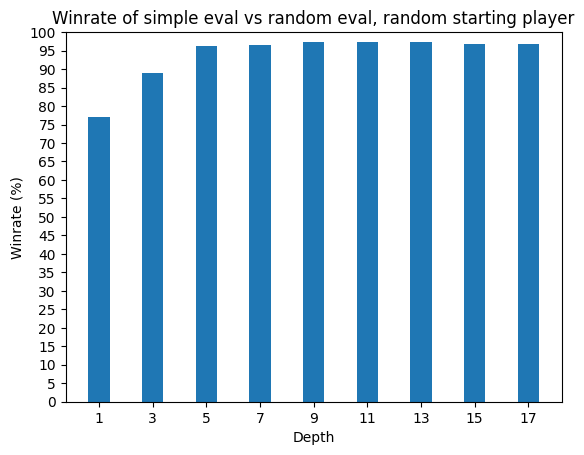

In [139]:
winrates = get_heuristic_winrate_across_depths(
    amount_of_tests=AMOUNT_OF_TESTS,
    player=Player.MAX,
    depths=TESTING_DEPTHS,
    evaluate_position_max=simple_eval,
    evaluate_position_min=random_eval,
    k=K
)

draw_winrates(winrates, f'Winrate of simple eval vs random eval, random starting player')

Gracza z losową ewaluacją pozycji można traktować jak gracza nie korzystającego z algorytmu minimax, a robiącego losowe ruchy

Nawet dla najniższych wartości głębokości przeszukiwań gracz korzystający z najprostrzej metody ewaluacji pozycji wygrywa większość gier, dla większej głębokości % wygranych dąży do 100%

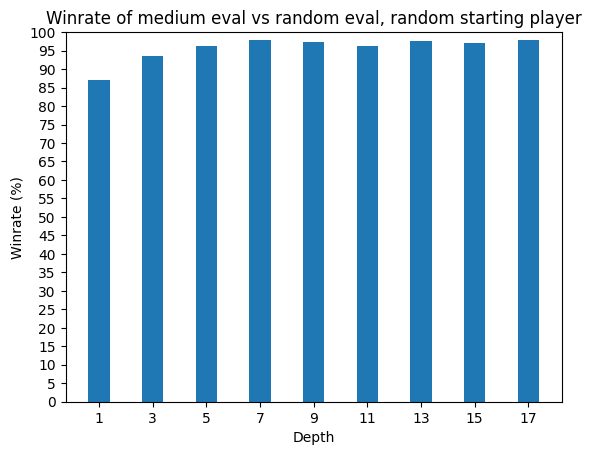

In [153]:
winrates = get_heuristic_winrate_across_depths(
    amount_of_tests=AMOUNT_OF_TESTS,
    player=Player.MAX,
    depths=TESTING_DEPTHS,
    evaluate_position_max=medium_eval,
    evaluate_position_min=random_eval,
    k=K
)

draw_winrates(winrates, f'Winrate of medium eval vs random eval, random starting player')

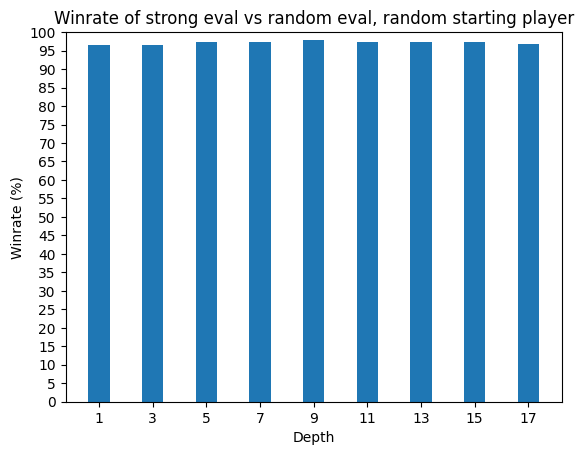

In [154]:
winrates = get_heuristic_winrate_across_depths(
    amount_of_tests=AMOUNT_OF_TESTS,
    player=Player.MAX,
    depths=TESTING_DEPTHS,
    evaluate_position_max=strong_eval,
    evaluate_position_min=random_eval,
    k=K
)

draw_winrates(winrates, f'Winrate of strong eval vs random eval, random starting player')

Po analizie wyników 3 ostatnich badań stwierdzam, że dla dowolnej, poprawnej heurystyki już dla głębokości przeszukiwań w okolicach 5 algorytm minimax pokonuje losowe ruchy w niemal 100% gier

Im silniejsza heurystyka, tym mniejsza głębokość przeszukiwań potrzebna do osiągnięcia zadowalających efektów, szczególnie, gdy pozwala ona na ewaluację pozycji dalekich od terminalnych (np. "strong eval")

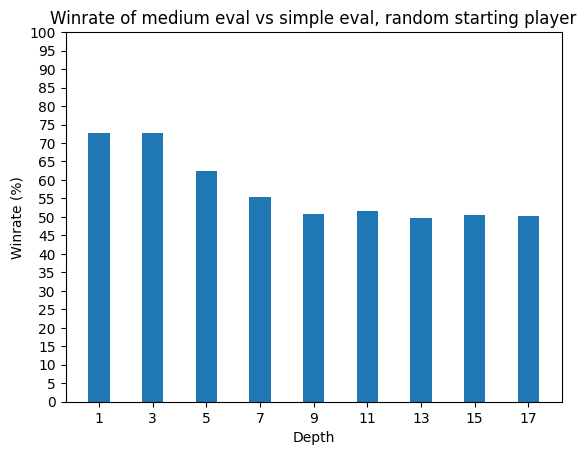

In [141]:
winrates = get_heuristic_winrate_across_depths(
    amount_of_tests=AMOUNT_OF_TESTS,
    player=Player.MAX,
    depths=TESTING_DEPTHS,
    evaluate_position_max=medium_eval,
    evaluate_position_min=simple_eval,
    k=K
)

draw_winrates(winrates, f'Winrate of medium eval vs simple eval, random starting player')

Heurysyka nazwana przeze mnie "medium eval" na małych głębokościach przeszukiwań częściej pokonuje "simple eval", jednak dla większych głębokości ich skuteczność jest podobna

Nie jest to dziwne, gdyż wynika to z implementacji "medium eval". Pozwala ona znać wynik gry jeden poziom przeszukiwań wyżej. Dla małych wartości głębokości "zejście" jeden poziom niżej potrafi mieć znaczenie, dla większych różnica "widzenia" jednego poziomu głębiej przestaje mieć znaczenie

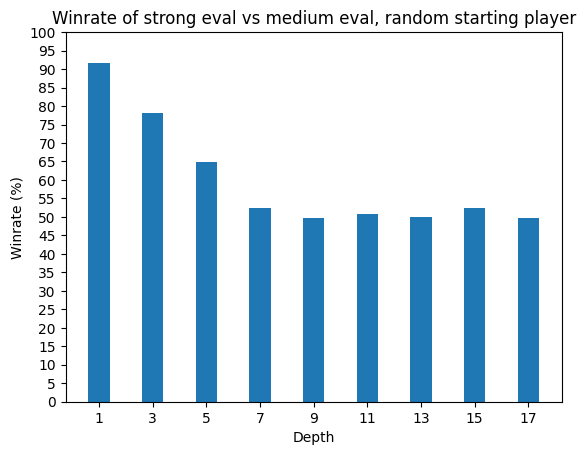

In [143]:
winrates = get_heuristic_winrate_across_depths(
    amount_of_tests=AMOUNT_OF_TESTS,
    player=Player.MAX,
    depths=TESTING_DEPTHS,
    evaluate_position_max=strong_eval,
    evaluate_position_min=medium_eval,
    k=K
)

draw_winrates(winrates, f'Winrate of strong eval vs medium eval, random starting player')

Dla niskich głębokości przeszukiwań silna ewaluacja wygrywa zdecydowaną większośc gier, jednakże tak jak w poprzednim przypadku, przy pogłębieniu przeszukiwań następuje wyrównanie wyników

Moja teoria jest taka, że ponieważ "strong eval" potrafi oszacować wynik gry niezależnie od ilości pozostałych żetonów, może od samego początku gry kierować gracza ku wygrywającym ruchom. W przeciwieństwie do niego, "medium eval" nie potrafi ewaluować pozycji w początkowej fazie gry, jeżeli głębokość przeszukiwania jest zbyt niska aby "dojrzeć" pozycje bliskie terminalnej

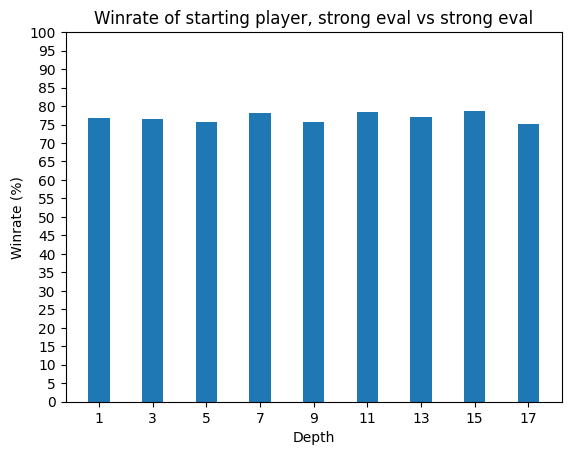

In [144]:
winrates = get_heuristic_winrate_across_depths(
    amount_of_tests=AMOUNT_OF_TESTS,
    player=Player.MAX,
    depths=TESTING_DEPTHS,
    evaluate_position_max=strong_eval,
    evaluate_position_min=strong_eval,
    k=K,
    starting_player=Player.MAX
)

draw_winrates(winrates, f'Winrate of starting player, strong eval vs strong eval')

Gdy obaj gracze korzystają z silnej ewaluacji, jedyne co decyduje o wyniku gry to gracz rozpoczynający ją oraz ilość żetonów na starcie

Na powyższym wykresie znajdują się % wygranych gracza rozpoczynającego dla ilości żetonów z przedziału <8, 20>. Patrząc na wyniki przypuszczam, że w tym przedziale ~77% ilości początkowych żetonów favoryzuje gracza rozpoczynającego

Dodatkowo można zauważyć, że dla zastosowanej heurysyki znaczenia nie ma głębokość przeszukiwań

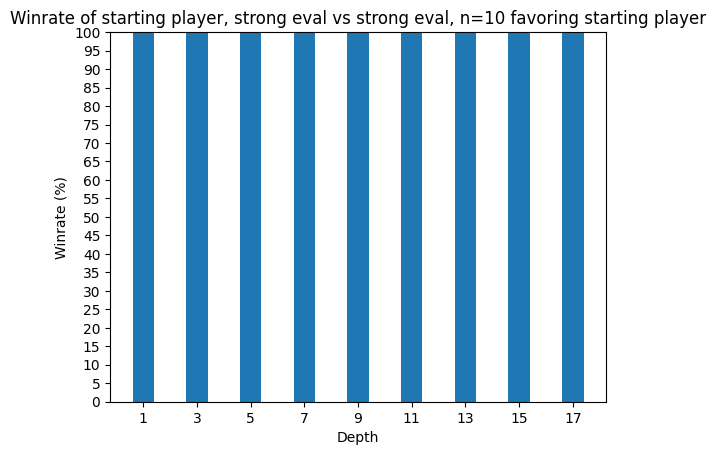

In [145]:
winrates = get_heuristic_winrate_across_depths(
    amount_of_tests=AMOUNT_OF_TESTS,
    player=Player.MAX,
    depths=TESTING_DEPTHS,
    evaluate_position_max=strong_eval,
    evaluate_position_min=strong_eval,
    k=K,
    starting_player=Player.MAX,
    n=10
)

draw_winrates(winrates, f'Winrate of starting player, strong eval vs strong eval, n=10 favoring starting player')

Dla zadanej początkowej liczbie żetonów równej 10 widać, że gracz rozpoczynający grę zawsze wygrywa

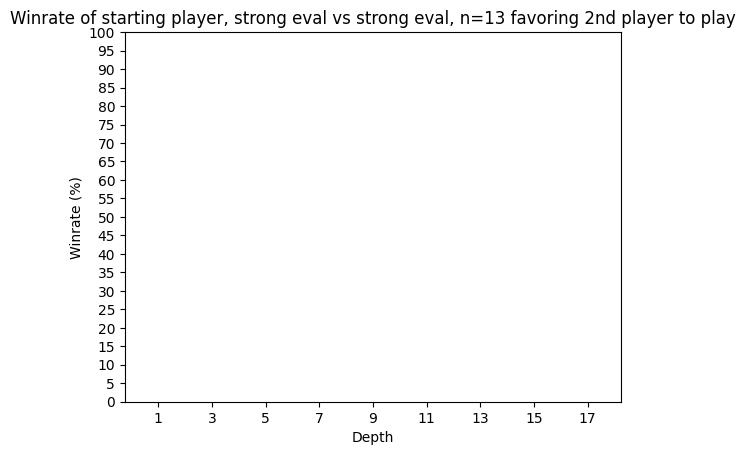

In [152]:
winrates = get_heuristic_winrate_across_depths(
    amount_of_tests=AMOUNT_OF_TESTS,
    player=Player.MAX,
    depths=TESTING_DEPTHS,
    evaluate_position_max=strong_eval,
    evaluate_position_min=strong_eval,
    k=K,
    starting_player=Player.MAX,
    n=13
)

draw_winrates(winrates, f'Winrate of starting player, strong eval vs strong eval, n=13 favoring 2nd player to play')

Analogicznie, dla zadanej początkowej liczbie żetonów równej 13 widać, że gracz rozpoczynający grę zawsze przegrywa

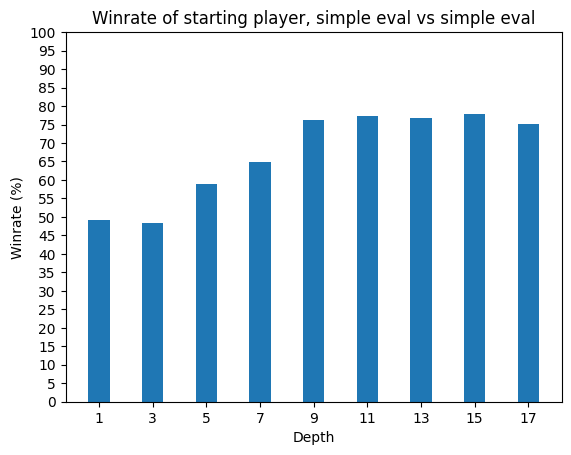

In [155]:
winrates = get_heuristic_winrate_across_depths(
    amount_of_tests=AMOUNT_OF_TESTS,
    player=Player.MAX,
    depths=TESTING_DEPTHS,
    evaluate_position_max=simple_eval,
    evaluate_position_min=simple_eval,
    k=K,
    starting_player=Player.MAX
)

draw_winrates(winrates, f'Winrate of starting player, simple eval vs simple eval')

Postanowiłem sprawdzić także % wygranych gier przez gracza rozpoczynającego korzystając z prostrzej heurystyki

Dla niskich głębokości przeszukiwań ruchy graczy przez większość gry są raczej losowe, więc nie dziwi mnie równowaga

Jednakże dla głębszych przeszukiwań częstotliwość wygranych gracza rozpoczynającego zauważalnie rośnie. Skłania mnie to do dwóch myśli: albo gra faworyzuje gracza rozpoczynającego, albo znowu jak w przypadku "strong eval", większość startowych liczb żetonów z przedziału <8, 20> faworyzuje gracza rozpoczynającego

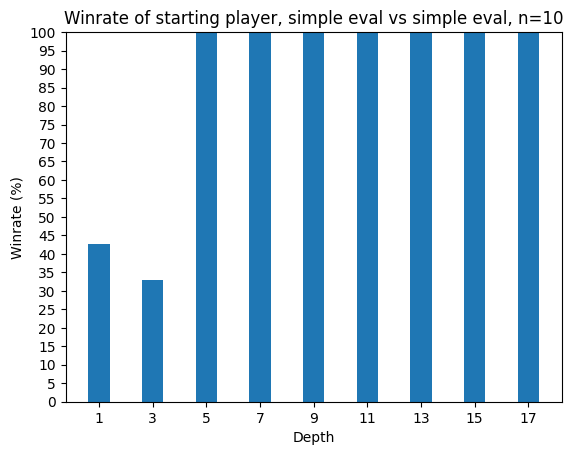

In [156]:
winrates = get_heuristic_winrate_across_depths(
    amount_of_tests=AMOUNT_OF_TESTS,
    player=Player.MAX,
    depths=TESTING_DEPTHS,
    evaluate_position_max=simple_eval,
    evaluate_position_min=simple_eval,
    k=K,
    starting_player=Player.MAX,
    n=10
)

draw_winrates(winrates, f'Winrate of starting player, simple eval vs simple eval, n=10')

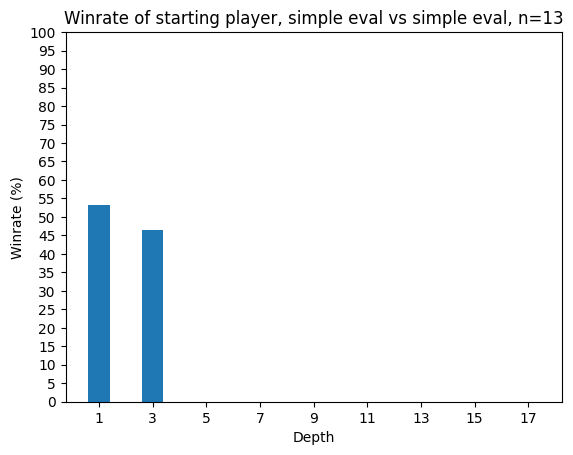

In [158]:
winrates = get_heuristic_winrate_across_depths(
    amount_of_tests=AMOUNT_OF_TESTS,
    player=Player.MAX,
    depths=TESTING_DEPTHS,
    evaluate_position_max=simple_eval,
    evaluate_position_min=simple_eval,
    k=K,
    starting_player=Player.MAX,
    n=13
)

draw_winrates(winrates, f'Winrate of starting player, simple eval vs simple eval, n=13')

Po przeanalizowaniu powyższych testów dochodzę do wniosku, że gra jest rozwiązywalna. Wynik gry zależy od tego kto zaczyna oraz jaka jest początkowa liczba żetonów nawet dla najprostszej heurystyki - jeżeli zapewnimy odpowiednią głębokość przeszukiwań

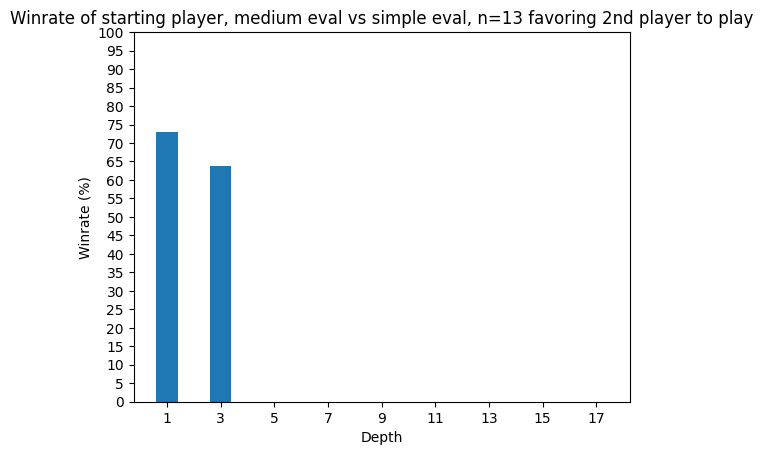

In [161]:
winrates = get_heuristic_winrate_across_depths(
    amount_of_tests=AMOUNT_OF_TESTS,
    player=Player.MAX,
    depths=TESTING_DEPTHS,
    evaluate_position_max=medium_eval,
    evaluate_position_min=simple_eval,
    k=K,
    starting_player=Player.MAX,
    n=13
)

draw_winrates(winrates, f'Winrate of starting player, medium eval vs simple eval, n=13 favoring 2nd player to play')

Z ciekawości sprawdziłem co się stanie, kiedy damy graczowi na przegranej pozycji lepszą heurystykę

Dla niskich głębokości przeszukiwań jego % wygranych wzrasta, jednakże nawet to nie pozwala mu wygrać jeśli głębokość jest wystarczająco duża

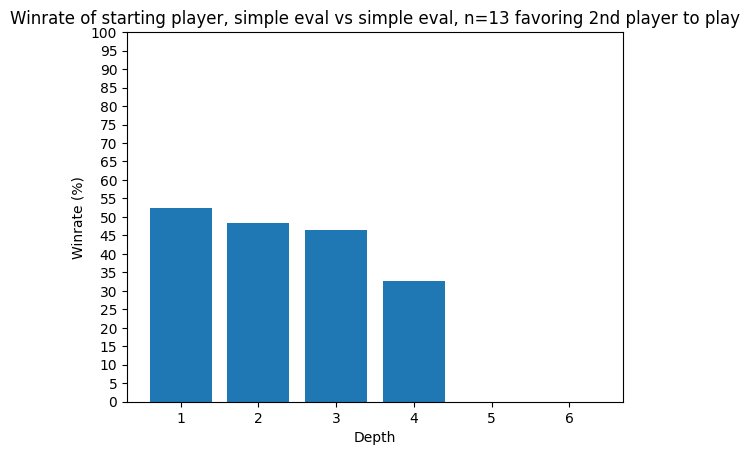

In [163]:
winrates = get_heuristic_winrate_across_depths(
    amount_of_tests=AMOUNT_OF_TESTS,
    player=Player.MAX,
    depths=[1, 2, 3, 4, 5, 6],
    evaluate_position_max=simple_eval,
    evaluate_position_min=simple_eval,
    k=K,
    starting_player=Player.MAX,
    n=13
)

draw_winrates(winrates, f'Winrate of starting player, simple eval vs simple eval, n=13 favoring 2nd player to play')

Jako, że cały czas badałem jedynie nieparzyste głębokości przeszukiwań, chciałem sprawdzić dla jakiej konkretnie wartości następuje "rozwiązanie" gry. Wynik to 5

# Wnioski

Zdaję sobię sprawę, że dużą część badań poświęciłem analizie działań różnych heurystyk. Nie wiem, czy testy które wykonałem wystarczająco spełniają polecenie "Następnie należy wykorzystać implementację do porównania skuteczności algorytmu dla różnych głębokości przeszukiwania", jednakże mam taką nadzieję

Podsumowując przemyślenia zebrane podczas wszystkich testów:
* algorytm minimax jest bardzo skuteczny przeciwko losowym ruchom nawet dla najniższych głębokości przeszukiwań
* skuteczność zbliża się do 100% dla głębokości przeszukiwań ~5
* dla zadanej w poleceniu gry jesteśmy w stanie określić końcowy wynik nie korzystając z algorytmu minimax
* korzystając z algorytmu minimax jesteśmy w stanie określić końcowy wynik gry nawet dla najprostszej heurystyki, jeżeli głębokość przeszukiwań jest odpowiednio duża

# Eksperymenty na temat rozwiązywalności gry

In [34]:
for n in range(1, 21):
    winrates = get_heuristic_winrate_across_depths(
        amount_of_tests=AMOUNT_OF_TESTS,
        player=Player.MAX,
        depths=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        evaluate_position_max=simple_eval,
        evaluate_position_min=simple_eval,
        k=K,
        starting_player=Player.MAX,
        n=n
    )
    solved_game_depths = [depth for depth, winrate in winrates.items() if int(winrate) in (0, 100)]
    min_solved_game_depth = min(solved_game_depths)
    winner = "1st player to play" if int(winrates[min_solved_game_depth]) == 100 else "2nd player to play"
    print(f'N: {n}, min depth solving game: {min_solved_game_depth}, winner: {winner}')

N: 1, min depth solving game: 1, winner: 2nd player to play
N: 2, min depth solving game: 1, winner: 1st player to play
N: 3, min depth solving game: 1, winner: 1st player to play
N: 4, min depth solving game: 1, winner: 1st player to play
N: 5, min depth solving game: 1, winner: 2nd player to play
N: 6, min depth solving game: 2, winner: 1st player to play
N: 7, min depth solving game: 3, winner: 1st player to play
N: 8, min depth solving game: 3, winner: 1st player to play
N: 9, min depth solving game: 3, winner: 2nd player to play
N: 10, min depth solving game: 4, winner: 1st player to play
N: 11, min depth solving game: 5, winner: 1st player to play
N: 12, min depth solving game: 5, winner: 1st player to play
N: 13, min depth solving game: 5, winner: 2nd player to play
N: 14, min depth solving game: 6, winner: 1st player to play
N: 15, min depth solving game: 7, winner: 1st player to play
N: 16, min depth solving game: 7, winner: 1st player to play
N: 17, min depth solving game: 7,

Zawsze wygrywa gracz rozpoczynający jeżeli warunek (n % (k+1) != 1) jest spełniony, w przeciwnym wypadku zawsze przegrywa. Warunek ten został przeze mnie wzięty z definicji strong_eval

To, czy gra jest rozwiązana dla danego n zależy od głębokości przeszukiwania. Nie jestem w stanie wymyślić sensownego wzoru opisującego tę zależność, jednak zauważyłem, że wymagana głębokość na przestrzeni n (przynajmniej w przedziale <3, 20>) trzyma się interesującego wzorca. Dla trzech kolejnych n potrzebna głębokość jest stała, zwiększa się o 1 w punktach n=4t+6 dla t całkowitych nieujemnych, a następnie ponownie zwiększa się o 1 itd.